In [16]:
from tutorials.utils.tutorial_utils import setup_notebook

setup_notebook()

# (Optional) Increase notebook width for all embedded cells to display properly
# from IPython.core.display import display, HTML

# display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
# display(HTML("<style>.container { width:100% !important; }</style>"))

In [17]:
# Useful imports
import os
from pathlib import Path
import tempfile
import hydra
#from nuplan.planning.simulation.planner.ml_planner.ml_planner import MLPlanner

## Get sample scenario data

In [18]:
import os
NUPLAN_DATA_ROOT = os.getenv('NUPLAN_DATA_ROOT', '../../nuplan/dataset')
NUPLAN_MAPS_ROOT = os.getenv('NUPLAN_MAPS_ROOT', '../../nuplan/dataset/maps')
NUPLAN_DB_FILES = os.getenv('NUPLAN_DB_FILES', '../../nuplan/dataset/nuplan-v1.1/splits/mini')
NUPLAN_MAP_VERSION = os.getenv('NUPLAN_MAP_VERSION', 'nuplan-maps-v1.0')

from nuplan.planning.script.builders.scenario_building_builder import build_scenario_builder
from nuplan.planning.script.builders.scenario_filter_builder import build_scenario_filter
from nuplan.planning.script.builders.worker_pool_builder import build_worker

### set up config file - edit in the config access to change ###
import hydra
CONFIG_PATH = "../nuplan/planning/script/config/common/myconfigs"
CONFIG_NAME = "scenario_access"
hydra.core.global_hydra.GlobalHydra.instance().clear()
hydra.initialize(config_path=CONFIG_PATH)
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[])
###

### create all scenario objects as specified in config file ###
scenario_builder = build_scenario_builder(cfg)
scenario_filter = build_scenario_filter(cfg.scenario_filter)
worker = build_worker(cfg)
scenarios = scenario_builder.get_scenarios(scenario_filter, worker) # List[AbstractScenario]

2023-08-10 20:28:58,687 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:18}  Building AbstractScenarioBuilder...
2023-08-10 20:28:58,701 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:21}  Building AbstractScenarioBuilder...DONE!
2023-08-10 20:28:58,701 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/scenario_filter_builder.py:35}  Building ScenarioFilter...
2023-08-10 20:28:58,703 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/scenario_filter_builder.py:44}  Building ScenarioFilter...DONE!
2023-08-10 20:28:58,704 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2023-08-10 20:28:58,704 INFO {/home/nishka/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: Sequential
2023-08-10 20:28:58,704 INFO {/home/nishka/nuplan-devkit/nuplan/planning/utils/multithreading/worker_p

## LQR Data

In [19]:
# from math import sqrt
# from nuplan.common.actor_state.tracked_objects_types import TrackedObjectType
# from nuplan.common.actor_state.state_representation import TimeDuration
# import numpy as np


# # imports for BFS
# from nuplan.common.actor_state.state_representation import Point2D
# from nuplan.common.maps.abstract_map import SemanticMapLayer
# from matplotlib import pyplot as plt

# from nuplan.common.actor_state.ego_state import EgoState
# from nuplan.common.maps.abstract_map_objects import LaneGraphEdgeMapObject
# from typing import List, Tuple
# from nuplan.planning.simulation.planner.utils.breadth_first_search import BreadthFirstSearch
# import math
# import torch

# from shapely import LineString
# import shapely

# class LQRData():
    
#     def __init__(self, scenario, closest=5):
#         self.s = scenario
        
#         self.data = {} # to be used for LQR
        
#         self.duration = self.s.duration_s # TimeDuration Object in seconds
#         self.num_frames = self.s.get_number_of_iterations() - 1
#         self.scenario_type = self.s.scenario_type
        
#         self.n = closest
#         self.closest_neighbors_id = []
        
#         # bfs vars
#         self.route_roadblocks = []
#         self.candidate_lane_edge_ids = []
#         self.init = self.s.initial_ego_state.center
#         self.fin = self.s.get_expert_goal_state()
        
#     def populate_data(self):
#         self.data['current_pos_gb'] = self.get_current_ego_pos_gb()
#         self.data['current_pos'] = self.get_current_ego_pos()
#         self.data['future_pos'] = self.get_future_ego_pos()
#         #self.data['current_neighbor_pos'] = self.get_current_neighbor_pos()
#         self.data['future_neighbor_pos'] = self.get_future_neighbor_pos_padded()
#         self.data['current_neighbor_pos'] = self.data['future_neighbor_pos'][:, 0, :]
#         self.data['current_lane'] = self.get_current_lane()
        
#         #self.relative_to_current_pos_gb()
#         self.add_batch_size_dimension()
    
#     # def relative_to_current_pos_gb(self):
# #         self.data['future_pos'] = self.data['future_pos'] - self.data['current_pos_gb']
# #         self.data['current_neighbor_pos'] = self.data['current_neighbor_pos'] - self.data['current_pos_gb']
# #         self.data['current_lane'] = self.data['current_lane'] - self.data['current_pos_gb']
        
            
#     def add_batch_size_dimension(self):
        
#         for key in self.data:
#             self.data[key] = torch.unsqueeze(self.data[key], 0)
    
#     def get_current_ego_pos_gb(self):
#         return torch.Tensor(self.get_xy_from_egostate(self.s.initial_ego_state))
    
#     def get_current_ego_pos(self):
#         return torch.Tensor((0, 0))
    
#     def get_future_ego_pos(self):
#         future_ego_pos = []
#         for ego in self.s.get_ego_future_trajectory(0, self.duration.time_s):
#             future_ego_pos.append(self.get_xy_from_egostate(ego))
#         return torch.Tensor(future_ego_pos)
    
#     def get_future_neighbor_pos_padded(self):
#         veh = {}
#         # for each frame
#         for det_track in s0.s.get_future_tracked_objects(0, s0.duration.time_s):
#             # for each tracked vehicle
#             for obj in det_track.tracked_objects.get_tracked_objects_of_type(TrackedObjectType.VEHICLE):
#                 veh[obj.track_token] = [(0.0, 0.0)] * s0.num_frames

#         # populate known vehicle positions
#         frame_id = 0
#         for det_track in s0.s.get_future_tracked_objects(0, s0.duration.time_s):
#             # for each tracked vehicle
#             for obj in det_track.tracked_objects.get_tracked_objects_of_type(TrackedObjectType.VEHICLE):
#                 veh[obj.track_token][frame_id] = self.get_xy_from_agent(obj)
#             frame_id += 1
        
#         return torch.Tensor(list(veh.values()))
        

#     def get_current_neighbor_pos(self):
        
#         neighbors = self.s.initial_tracked_objects.tracked_objects.get_tracked_objects_of_type(TrackedObjectType.VEHICLE)
        
#         neighbors = sorted(neighbors, key=lambda ag:self.dist(self.data['current_pos_gb'], 
#                                                                self.get_xy_from_agent(ag)))
#         assert(self.n <= len(neighbors))
#         if self.n < 0:
#             near_neighbors = neighbors
#         else:
#             near_neighbors = neighbors[:self.n]
#         self.closest_neighbors_id = [x.track_token for x in near_neighbors]
#         return torch.Tensor([self.get_xy_from_agent(ag) for ag in near_neighbors])
    
#     def get_xy_from_agent(self, agent):
#         return (agent.center.x, agent.center.y)
    
#     def get_xy_from_egostate(self, ego):
#         return ego.waypoint._oriented_box.center.x, ego.waypoint._oriented_box.center.y
    
#     def dist(self, a, b):
#         return sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)
    
#     def get_current_lane(self):
#         # get current lane info
#         bfs_output = self.get_bfs_path()
        
#         full_bfs = []
#         for lane in bfs_output:
#             full_bfs += lane.baseline_path.discrete_path
        
#         ref_path = self.trim_ref_path(full_bfs)
        
#         return torch.Tensor(self.interpolate_to_dim(ref_path))
    
#     def interpolate_to_dim(self, ref_path):
#         line = LineString(ref_path)
#         num_pts = s0.data['future_pos'].shape[0]
#         distances = np.linspace(0, line.length, num_pts)
#         points = [line.interpolate(distance) for distance in distances]
#         return [(pt.x, pt.y) for pt in points]
        
        
#     def trim_ref_path(self, full_bfs):
        
#         init_dist = float('inf')
#         fin_dist = float('inf')

#         init_id = 0
#         fin_id = 0
        
#         for idx in range(len(full_bfs)):
#             if init_dist > full_bfs[idx].distance_to(self.init):
#                 init_dist = full_bfs[idx].distance_to(self.init)
#                 init_id = idx
#             if fin_dist > full_bfs[idx].distance_to(self.fin):
#                 fin_dist = full_bfs[idx].distance_to(self.fin)
#                 fin_id = idx
        
#         ref_path = full_bfs[init_id:fin_id+1]
#         return [(pt.x, pt.y) for pt in ref_path] #, [pt.y for pt in ref_path]

    
#     def get_bfs_path(self):
#         # get route plan from map
#         route_roadblocks_ids = self.s.get_route_roadblock_ids()

#         self.route_roadblocks = []
#         for id_ in route_roadblocks_ids:
#             block = self.s.map_api.get_map_object(id_, SemanticMapLayer.ROADBLOCK)
#             block = block or self.s.map_api.get_map_object(id_, SemanticMapLayer.ROADBLOCK_CONNECTOR)
#             self.route_roadblocks.append(block)

#         # candidate lane IDs
#         self.candidate_lane_edge_ids = [edge.id for block in self.route_roadblocks 
#                                    if block for edge in block.interior_edges]
        
#         current_lane_path, found = self.bfs(self.s.initial_ego_state)
#         assert(found == True)
#         return current_lane_path
        
#     def get_starting_edge(self, ego_state: EgoState) -> LaneGraphEdgeMapObject:
#         starting_edge = None
#         closest_dist = math.inf
#         found_on_roadblock = False
#         for edge in self.route_roadblocks[0].interior_edges + self.route_roadblocks[1].interior_edges:
#             if edge.contains_point(ego_state.center):
#                 starting_edge = edge
#                 found_on_roadblock = True
#                 break
#             # case ego does not start on a road block
#             distance = edge.polygon.distance(ego_state.car_footprint.geometry)
#             if distance < closest_dist:
#                 starting_edge = edge
#                 closest_dist = distance

#         if not found_on_roadblock:
#             print('Picking closest approx for starting roadblock')
#         return starting_edge
    
#     def bfs(self, ego_state: EgoState) -> Tuple[List[LaneGraphEdgeMapObject], bool]:
#         starting_edge = self.get_starting_edge(ego_state)
#         graph_search = BreadthFirstSearch(starting_edge, self.candidate_lane_edge_ids)
#         offset = 1 if starting_edge.get_roadblock_id() == self.route_roadblocks[1].id else 0
#         route_plan, path_found = graph_search.search(self.route_roadblocks[-1], len(self.route_roadblocks[offset:]))
#         if not path_found:
#             logger.warning('Path not found')
#         return route_plan, path_found
        

In [30]:
from math import sqrt
from nuplan.common.actor_state.tracked_objects_types import TrackedObjectType
from nuplan.common.actor_state.state_representation import TimeDuration
import numpy as np


# imports for BFS
from nuplan.common.actor_state.state_representation import Point2D
from nuplan.common.maps.abstract_map import SemanticMapLayer
from matplotlib import pyplot as plt

from nuplan.common.actor_state.ego_state import EgoState
from nuplan.common.maps.abstract_map_objects import LaneGraphEdgeMapObject
from typing import List, Tuple
from nuplan.planning.simulation.planner.utils.breadth_first_search import BreadthFirstSearch
import math
import torch

from shapely import LineString
import shapely

class LQRData():
    
    def __init__(self, scenario, closest=5, start_iter=0, horizon=20):
        self.s = scenario
        
        self.data = {} # to be used for LQR
        
        self.duration = self.s.duration_s # TimeDuration Object in seconds
        self.num_frames = self.s.get_number_of_iterations() - 1
        self.scenario_type = self.s.scenario_type

        self.start_iter = start_iter
        self.horizon = horizon
        self.horizon_duration = self.duration.time_s * (float(self.horizon)/self.num_frames)
        
        self.n = closest
        self.closest_neighbors_id = []

        self.new_data = {}
        
        # bfs vars
        self.route_roadblocks = []
        self.candidate_lane_edge_ids = []
        #self.init = self.s.initial_ego_state.center
        #self.fin = self.s.get_expert_goal_state()
        self.init = self.s.get_ego_state_at_iteration(self.start_iter).center
        self.fin = self.s.get_ego_state_at_iteration(self.start_iter + self.horizon).center
        
    def populate_data(self):
        self.data['current_pos_gb'] = self.get_current_ego_pos_gb()
        self.data['current_pos'] = self.get_current_ego_pos()
        self.data['future_pos'] = self.get_future_ego_pos()
        #self.data['current_neighbor_pos'] = self.get_current_neighbor_pos()
        self.data['future_neighbor_pos'] = self.get_future_neighbor_pos_padded()
        self.data['current_neighbor_pos'] = self.data['future_neighbor_pos'][:, 0, :]
        self.data['current_lane'] = self.get_current_lane()
        
        #self.relative_to_current_pos_gb()
        self.add_batch_size_dimension()
        self.single_neighbor_centered()
    
    # def relative_to_current_pos_gb(self):
#         self.data['future_pos'] = self.data['future_pos'] - self.data['current_pos_gb']
#         self.data['current_neighbor_pos'] = self.data['current_neighbor_pos'] - self.data['current_pos_gb']
#         self.data['current_lane'] = self.data['current_lane'] - self.data['current_pos_gb']

    def single_neighbor_centered(self):
        # this prepares the data to only have one neighbor and centers it to the beginning of the ego position
        self.new_data['current_pos_gb'] = s0.data['current_pos_gb']
        self.new_data['current_pos'] = s0.data['current_pos']
        self.new_data['future_pos'] = (s0.data['future_pos'] - s0.data['current_pos_gb'])
        self.new_data['current_lane'] = (s0.data['current_lane'] - s0.data['current_pos_gb'])
        self.new_data['future_neighbor_pos'] = s0.data['future_neighbor_pos'][:, [0], :, :] - s0.data['current_pos_gb']
        self.new_data['current_neighbor_pos'] = s0.data['current_neighbor_pos'][:, [0], :] - s0.data['current_pos_gb']
            
    def add_batch_size_dimension(self):
        
        for key in self.data:
            self.data[key] = torch.unsqueeze(self.data[key], 0)
    
    def get_current_ego_pos_gb(self):
        return torch.Tensor(self.get_xy_from_egostate(self.s.get_ego_state_at_iteration(self.start_iter)))
    
    def get_current_ego_pos(self):
        return torch.Tensor((0, 0))
    
    def get_future_ego_pos(self):
        future_ego_pos = []
        for ego in self.s.get_ego_future_trajectory(self.start_iter, self.horizon_duration, num_samples=self.horizon):
            future_ego_pos.append(self.get_xy_from_egostate(ego))
        return torch.Tensor(future_ego_pos)
    
    def get_future_neighbor_pos_padded(self):
        veh = {}
        # for each frame
        for det_track in self.s.get_future_tracked_objects(self.start_iter, time_horizon=self.horizon_duration, num_samples=self.horizon):
            # for each tracked vehicle
            for obj in det_track.tracked_objects.get_tracked_objects_of_type(TrackedObjectType.VEHICLE):
                veh[obj.track_token] = [(0.0, 0.0)] * self.horizon

        # populate known vehicle positions
        frame_id = 0
        for det_track in self.s.get_future_tracked_objects(self.start_iter, time_horizon=self.horizon_duration, num_samples=self.horizon):
            # for each tracked vehicle
            for obj in det_track.tracked_objects.get_tracked_objects_of_type(TrackedObjectType.VEHICLE):
                veh[obj.track_token][frame_id] = self.get_xy_from_agent(obj)
            frame_id += 1
        
        return torch.Tensor(list(veh.values()))#[:, self.start_iter:self.start_iter+self.horizon, :]
        

    def get_current_neighbor_pos(self):
        
        #neighbors = self.s.initial_tracked_objects.tracked_objects.get_tracked_objects_of_type(TrackedObjectType.VEHICLE)
        neighbors = self.s.get_tracked_objects_at_iteration(self.start_iter).tracked_objects.get_tracked_objects_of_type(TrackedObjectType.VEHICLE)
        neighbors = sorted(neighbors, key=lambda ag:self.dist(self.data['current_pos_gb'], 
                                                               self.get_xy_from_agent(ag)))
        assert(self.n <= len(neighbors))
        if self.n < 0:
            near_neighbors = neighbors
        else:
            near_neighbors = neighbors[:self.n]
        self.closest_neighbors_id = [x.track_token for x in near_neighbors]
        return torch.Tensor([self.get_xy_from_agent(ag) for ag in near_neighbors])
    
    def get_xy_from_agent(self, agent):
        return (agent.center.x, agent.center.y)
    
    def get_xy_from_egostate(self, ego):
        return ego.waypoint._oriented_box.center.x, ego.waypoint._oriented_box.center.y
    
    def dist(self, a, b):
        return sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)
    
    def get_current_lane(self):
        # get current lane info
        bfs_output = self.get_bfs_path()
        
        full_bfs = []
        for lane in bfs_output:
            full_bfs += lane.baseline_path.discrete_path
        
        ref_path = self.trim_ref_path(full_bfs)
        
        return torch.Tensor(self.interpolate_to_dim(ref_path))
    
    def interpolate_to_dim(self, ref_path):
        line = LineString(ref_path)
        num_pts = self.horizon
        #num_pts = s0.data['future_pos'].shape[0]
        #num_pts = self.s.get_number_of_iterations() - 1
        #num_pts = self.num_frames
        distances = np.linspace(0, line.length, num_pts)
        points = [line.interpolate(distance) for distance in distances]
        return [(pt.x, pt.y) for pt in points]
        
        
    def trim_ref_path(self, full_bfs):
        
        init_dist = float('inf')
        fin_dist = float('inf')

        init_id = 0
        fin_id = 0
        
        for idx in range(len(full_bfs)):
            if init_dist > full_bfs[idx].distance_to(self.init):
                init_dist = full_bfs[idx].distance_to(self.init)
                init_id = idx
            if fin_dist > full_bfs[idx].distance_to(self.fin):
                fin_dist = full_bfs[idx].distance_to(self.fin)
                fin_id = idx
        
        ref_path = full_bfs[init_id:fin_id+1]
        return [(pt.x, pt.y) for pt in ref_path] #, [pt.y for pt in ref_path]

    
    def get_bfs_path(self):
        # get route plan from map
        route_roadblocks_ids = self.s.get_route_roadblock_ids()

        self.route_roadblocks = []
        for id_ in route_roadblocks_ids:
            block = self.s.map_api.get_map_object(id_, SemanticMapLayer.ROADBLOCK)
            block = block or self.s.map_api.get_map_object(id_, SemanticMapLayer.ROADBLOCK_CONNECTOR)
            self.route_roadblocks.append(block)

        # candidate lane IDs
        self.candidate_lane_edge_ids = [edge.id for block in self.route_roadblocks 
                                   if block for edge in block.interior_edges]
        
        current_lane_path, found = self.bfs(self.s.initial_ego_state)
        assert(found == True)
        return current_lane_path
        
    def get_starting_edge(self, ego_state: EgoState) -> LaneGraphEdgeMapObject:
        starting_edge = None
        closest_dist = math.inf
        found_on_roadblock = False
        for edge in self.route_roadblocks[0].interior_edges + self.route_roadblocks[1].interior_edges:
            if edge.contains_point(ego_state.center):
                starting_edge = edge
                found_on_roadblock = True
                break
            # case ego does not start on a road block
            distance = edge.polygon.distance(ego_state.car_footprint.geometry)
            if distance < closest_dist:
                starting_edge = edge
                closest_dist = distance

        if not found_on_roadblock:
            print('Picking closest approx for starting roadblock')
        return starting_edge
    
    def bfs(self, ego_state: EgoState) -> Tuple[List[LaneGraphEdgeMapObject], bool]:
        starting_edge = self.get_starting_edge(ego_state)
        graph_search = BreadthFirstSearch(starting_edge, self.candidate_lane_edge_ids)
        offset = 1 if starting_edge.get_roadblock_id() == self.route_roadblocks[1].id else 0
        route_plan, path_found = graph_search.search(self.route_roadblocks[-1], len(self.route_roadblocks[offset:]))
        if not path_found:
            logger.warning('Path not found')
        return route_plan, path_found
        

## Running LQR Planner

In [28]:
from typing import List, Type
import itertools
from nuplan.planning.simulation.observation.observation_type import DetectionsTracks, Observation
from nuplan.planning.simulation.planner.abstract_planner import AbstractPlanner, PlannerInitialization, PlannerInput
from nuplan.planning.scenario_builder.abstract_scenario import AbstractScenario
from nuplan.planning.simulation.trajectory.abstract_trajectory import AbstractTrajectory
from nuplan.planning.simulation.trajectory.interpolated_trajectory import InterpolatedTrajectory


from lqr import LQRPlanner

class NuPlanLQRPlanner(AbstractPlanner):
    """
    Planner which just looks as future GT and returns it as a desired trajectory
    the input to this planner are detections.
    """

    # Inherited property, see superclass.
    requires_scenario: bool = True

    def __init__(self, scenario: AbstractScenario, future_time_horizon: float):
        """
        Constructor of LogFuturePlanner.
        :param scenario: The scenario the planner is running on.
        :param num_poses: The number of poses to plan for.
        :param future_time_horizon: [s] The horizon length to plan for.
        """
        self._scenario = scenario
        self.i = 0
        #self._num_poses = num_poses
        #self._future_time_horizon = future_time_horizon
        self._horizon = horizon
        self._trajectory: Optional[AbstractTrajectory] = None

    def initialize(self, initialization: List[PlannerInitialization]) -> None:
        """Inherited, see superclass."""
        pass

    def name(self) -> str:
        """Inherited, see superclass."""
        return self.__class__.__name__

    def observation_type(self) -> Type[Observation]:
        """Inherited, see superclass."""
        return DetectionsTracks  # type: ignore

    def compute_planner_trajectory(self, current_input: PlannerInput) -> AbstractTrajectory:
        """Inherited, see superclass."""
        #print(f'CURRENT PLANNER TRAJECTORY IS CALLED: {self.i}')
        #self.i += 1
        #current_state = self._scenario.get_ego_state_at_iteration(current_input.iteration.index)
        s0 = LQRData(self._scenario, closest=-1, start_iter=current_input.iteration.index, horizon=self._horizon)
        s0.populate_data()
        lqrplanner = LQRPlanner()
        traj = planner.forward(s0.new_data)['traj'].detach().numpy()
        states = ##### list of waypoints
        # waypoints require oriented box, timepoint, and velocity.
        self._trajectory = InterpolatedTrajectory(list(itertools.chain([current_state], states)))
        # try:
        #     states = self._scenario.get_ego_future_trajectory(
        #         current_input.iteration.index, self._future_time_horizon
        #     )
        #     print(states)
        #     
        #self._trajectory = InterpolatedTrajectory(list(itertools.chain([current_state], states)))
        # except AssertionError:
        #     logger.warning("Cannot retrieve future ego trajectory. Using previous computed trajectory.")
        #     if self._trajectory is None:
        #         raise RuntimeError("Future ego trajectory cannot be retrieved from the scenario!")

        return self._trajectory

In [29]:
#scenarios
#planner = NuPlanLQRPlanner(scenarios[0], 20, 3)
scenario = scenarios[6]
planner = NuPlanLQRPlanner(scenario, future_time_horizon=3)

## Simulation without dataset config - choose a scenario yourself

In [22]:
from tutorials.utils.tutorial_utils import construct_simulation_hydra_paths
# Location of paths with all simulation configs
BASE_CONFIG_PATH = os.path.join(os.getenv('NUPLAN_TUTORIAL_PATH', ''), '../nuplan/planning/script')
simulation_hydra_paths = construct_simulation_hydra_paths(BASE_CONFIG_PATH)

# Create a temporary directory to store the simulation artifacts
#SAVE_DIR = tempfile.mkdtemp()
SAVE_DIR = '/home/nishka/nuplan-devkit/tutorials/saved_simulations'

# Select simulation parameters
EGO_CONTROLLER = 'perfect_tracking_controller'  # [log_play_back_controller, perfect_tracking_controller]
OBSERVATION = 'box_observation'  # [box_observation, idm_agents_observation, lidar_pc_observation]

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=simulation_hydra_paths.config_path)

#Compose the configuration
cfg = hydra.compose(config_name=simulation_hydra_paths.config_name, overrides=[
    f'group={SAVE_DIR}',
    f'experiment_name=custom_planner',
    f'job_name=custom_planner',
    'experiment=${experiment_name}/${job_name}',
    'worker=sequential',
    f'ego_controller={EGO_CONTROLLER}',
    f'observation={OBSERVATION}',
    f'hydra.searchpath=[{simulation_hydra_paths.common_dir}, {simulation_hydra_paths.experiment_dir}, "../nuplan/planning/script/config/simulation"]',
    'output_dir=${group}/${experiment}',
    #*DATASET_PARAMS,
])

In [23]:
from nuplan.planning.simulation.controller.abstract_controller import AbstractEgoController
from nuplan.planning.simulation.simulation_time_controller.abstract_simulation_time_controller import (
    AbstractSimulationTimeController,
)
from nuplan.planning.simulation.observation.abstract_observation import AbstractObservation
from nuplan.planning.script.builders.observation_builder import build_observations

from nuplan.planning.simulation.simulation_setup import SimulationSetup
from nuplan.planning.simulation.simulation import Simulation
from nuplan.planning.simulation.runner.simulations_runner import SimulationRunner
from nuplan.planning.simulation.callback.metric_callback import MetricCallback
from nuplan.planning.simulation.callback.multi_callback import MultiCallback
from nuplan.planning.script.builders.simulation_callback_builder import (
    build_callbacks_worker,
    build_simulation_callbacks,
)

from nuplan.planning.script.builders.metric_builder import build_metrics_engines
from hydra.utils import instantiate
from nuplan.planning.script.utils import run_runners, set_default_path, set_up_common_builder

import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


profiler_name = 'building_simulation'
common_builder = set_up_common_builder(cfg=cfg, profiler_name=profiler_name)
callbacks_worker_pool = build_callbacks_worker(cfg)
callbacks = build_simulation_callbacks(cfg=cfg, output_dir=common_builder.output_dir, worker=callbacks_worker_pool)

# given a scenario in scenarios[0] and a planner NuPlanLQRPlanner - make the simulation object

ego_controller: AbstractEgoController = instantiate(cfg.ego_controller, scenario=scenario)
simulation_time_controller: AbstractSimulationTimeController = instantiate(cfg.simulation_time_controller, scenario=scenario)
observations: AbstractObservation = build_observations(cfg.observation, scenario=scenario)


metric_engines_map = {}
# if cfg.run_metric:
logger.info('Building metric engines...')
metric_engines_map = build_metrics_engines(cfg=cfg, scenarios=[scenario])
logger.info('Building metric engines...DONE')
# else:
#     logger.info('Metric engine is disable')
# Metric Engine
metric_engine = metric_engines_map.get(scenario.scenario_type, None)

stateful_callbacks = [MetricCallback(metric_engine=metric_engine, worker_pool=callbacks_worker_pool)]

if "simulation_log_callback" in cfg.callback:
    stateful_callbacks.append(
        instantiate(cfg.callback["simulation_log_callback"], worker_pool=callbacks_worker_pool)
    )

# Construct simulation and manager
simulation_setup = SimulationSetup(
                time_controller=simulation_time_controller,
                observations=observations,
                ego_controller=ego_controller,
                scenario=scenario,
            )

simulation = Simulation(
    simulation_setup=simulation_setup,
    callback=MultiCallback(callbacks + stateful_callbacks),
    simulation_history_buffer_duration=cfg.simulation_history_buffer_duration,
)

runner = SimulationRunner(simulation, planner)

2023-08-10 20:29:16,146 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:20}  Building MultiMainCallback...
2023-08-10 20:29:16,167 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:35}  Building MultiMainCallback: 4...DONE!
2023-08-10 20:29:16,364 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2023-08-10 20:29:16,365 INFO {/home/nishka/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: Sequential
2023-08-10 20:29:16,365 INFO {/home/nishka/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 1
Number of GPUs per node: 0
Number of threads across all nodes: 1
2023-08-10 20:29:16,365 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2023-08-10 20:29:16,365 INFO {/home/nishka/nuplan

2023-08-10 20:29:19,644 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/utils.py:138}  Executing runners...
2023-08-10 20:29:19,645 INFO {/home/nishka/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:82}  Starting 1 simulations using Sequential!
CURRENT PLANNER TRAJECTORY IS CALLED: 0
<generator object get_sampled_ego_states_from_db at 0x7fa037525430>
CURRENT PLANNER TRAJECTORY IS CALLED: 1
<generator object get_sampled_ego_states_from_db at 0x7fa037525430>
CURRENT PLANNER TRAJECTORY IS CALLED: 2
<generator object get_sampled_ego_states_from_db at 0x7fa037525430>
CURRENT PLANNER TRAJECTORY IS CALLED: 3
<generator object get_sampled_ego_states_from_db at 0x7fa037525430>
CURRENT PLANNER TRAJECTORY IS CALLED: 4
<generator object get_sampled_ego_states_from_db at 0x7fa037525430>
CURRENT PLANNER TRAJECTORY IS CALLED: 5
<generator object get_sampled_ego_states_from_db at 0x7fa037525430>
CURRENT PLANNER TRAJECTORY IS CALLED: 6
<generator object get_sampled_ego_states_from_d

Rendering histograms: 100%|██████████████████████| 7/7 [00:01<00:00,  6.29it/s]


2023-08-10 20:29:27,522 INFO {/home/nishka/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_summary_callback.py:344}  Metric summary: 00:00:02 [HH:MM:SS]


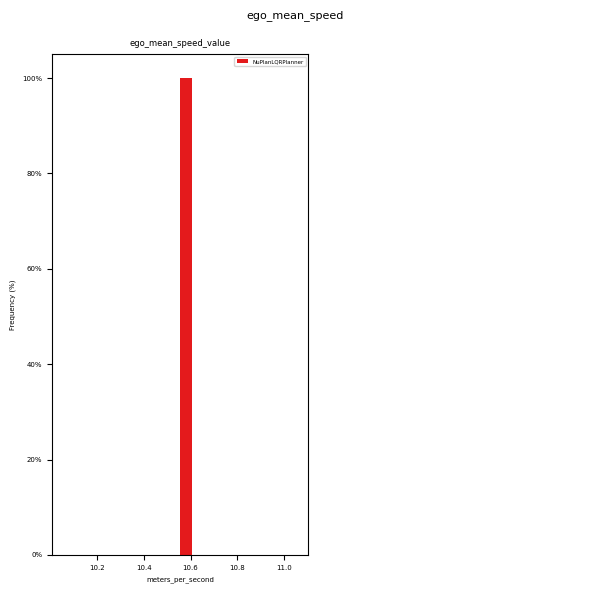

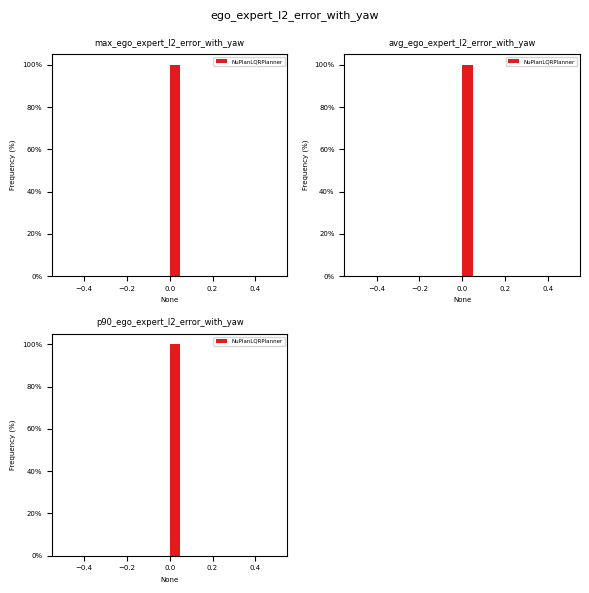

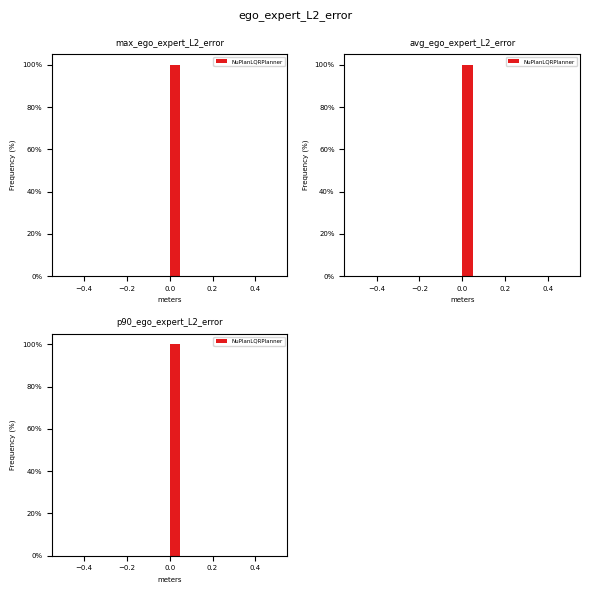

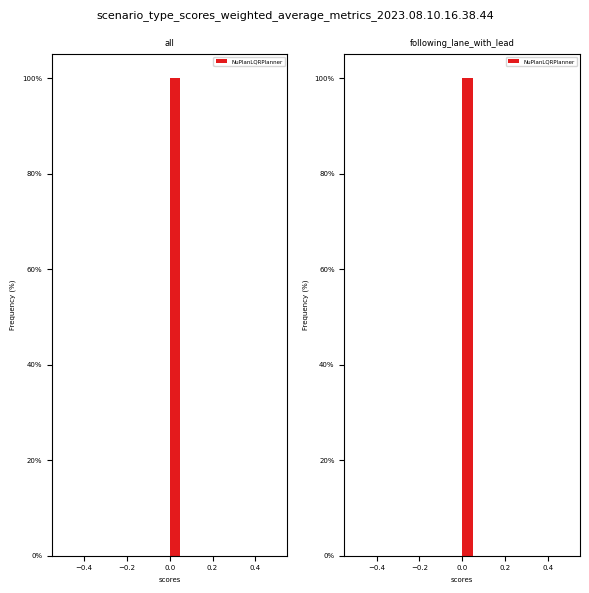

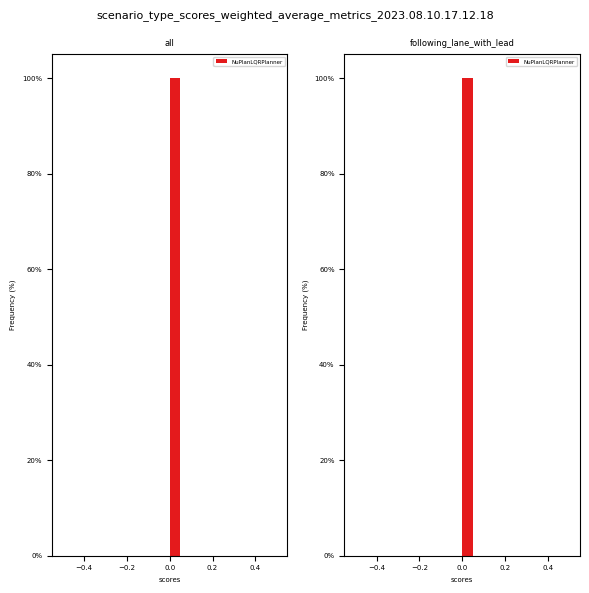

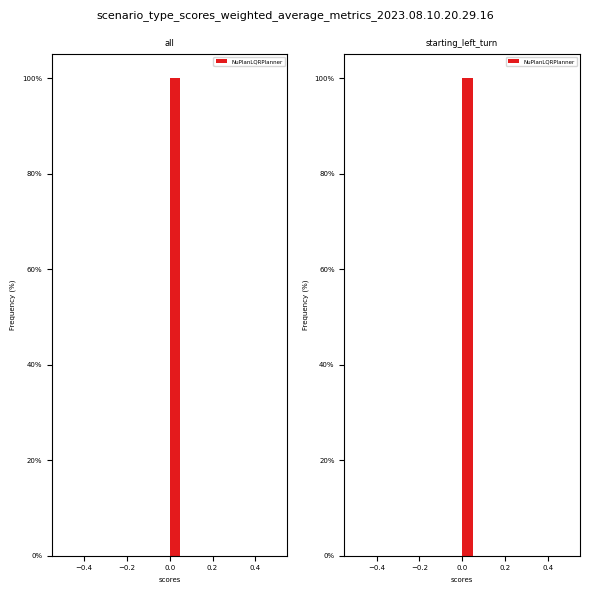

In [24]:
run_runners(runners=[runner], common_builder=common_builder, cfg=cfg, profiler_name='running_simulation')

## Simulation Config

In [10]:
# from tutorials.utils.tutorial_utils import construct_simulation_hydra_paths

# # Location of paths with all simulation configs
# BASE_CONFIG_PATH = os.path.join(os.getenv('NUPLAN_TUTORIAL_PATH', ''), '../nuplan/planning/script')
# simulation_hydra_paths = construct_simulation_hydra_paths(BASE_CONFIG_PATH)

# # Create a temporary directory to store the simulation artifacts
# SAVE_DIR = tempfile.mkdtemp()
# SAVE_DIR = 'saved_simulations'

# # Select simulation parameters
# EGO_CONTROLLER = 'perfect_tracking_controller'  # [log_play_back_controller, perfect_tracking_controller]
# OBSERVATION = 'box_observation'  # [box_observation, idm_agents_observation, lidar_pc_observation]



# DATASET_PARAMS = [
#     'scenario_builder=nuplan_mini',  # use nuplan mini database (2.5h of 8 autolabeled logs in Las Vegas)
#     #'scenario_filter=one_continuous_log',  # simulate only one log
#     "scenario_filter=one_of_each_scenario_type",
#     #"scenario_filter.log_names=['2021.07.16.20.45.29_veh-35_01095_01486']",
#     #"scenario_filter.log_names=['2021.06.08.14.35.24_veh-26_02555_03004']",
#     "scenario_filter.scenario_tokens=['485e78d3d4035b52']"
#     #'scenario_filter.limit_total_scenarios=1',  # use 2 total scenarios
# ]

# Initialize configuration management system
#hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
#hydra.initialize(config_path=simulation_hydra_paths.config_path)

# Compose the configuration
# cfg = hydra.compose(config_name=simulation_hydra_paths.config_name, overrides=[
#     f'group={SAVE_DIR}',
#     f'experiment_name=planner_tutorial',
#     f'job_name=planner_tutorial',
#     'experiment=${experiment_name}/${job_name}',
#     'worker=sequential',
#     f'ego_controller={EGO_CONTROLLER}',
#     f'observation={OBSERVATION}',
#     f'hydra.searchpath=[{simulation_hydra_paths.common_dir}, {simulation_hydra_paths.experiment_dir}]',
#     'output_dir=${group}/${experiment}',
#     *DATASET_PARAMS,
# ])

In [11]:
# from nuplan.planning.script.run_simulation import run_simulation as main_simulation
# Run the simulation loop (real-time visualization not yet supported, see next section for visualization)
# main_simulation(cfg, planner)

In [25]:
# Get nuBoard simulation file for visualization later on
simulation_file = [str(file) for file in Path(cfg.output_dir).iterdir() if file.is_file() and file.suffix == '.nuboard']

In [26]:
simulation_file

['/home/nishka/nuplan-devkit/tutorials/saved_simulations/custom_planner/custom_planner/nuboard_1691700641.nuboard',
 '/home/nishka/nuplan-devkit/tutorials/saved_simulations/custom_planner/custom_planner/nuboard_1691701106.nuboard',
 '/home/nishka/nuplan-devkit/tutorials/saved_simulations/custom_planner/custom_planner/nuboard_1691713756.nuboard',
 '/home/nishka/nuplan-devkit/tutorials/saved_simulations/custom_planner/custom_planner/nuboard_1691701010.nuboard',
 '/home/nishka/nuplan-devkit/tutorials/saved_simulations/custom_planner/custom_planner/nuboard_1691699925.nuboard',
 '/home/nishka/nuplan-devkit/tutorials/saved_simulations/custom_planner/custom_planner/nuboard_1691701229.nuboard',
 '/home/nishka/nuplan-devkit/tutorials/saved_simulations/custom_planner/custom_planner/nuboard_1691700916.nuboard',
 '/home/nishka/nuplan-devkit/tutorials/saved_simulations/custom_planner/custom_planner/nuboard_1691701350.nuboard',
 '/home/nishka/nuplan-devkit/tutorials/saved_simulations/custom_planner/

## Launch NuBoard

In [14]:
from tutorials.utils.tutorial_utils import construct_nuboard_hydra_paths

# Location of paths with all nuBoard configs
nuboard_hydra_paths = construct_nuboard_hydra_paths(BASE_CONFIG_PATH)

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=nuboard_hydra_paths.config_path)

# Compose the configuration
cfg = hydra.compose(config_name=nuboard_hydra_paths.config_name, overrides=[
    'scenario_builder=nuplan_mini',  # set the database (same as simulation) used to fetch data for visualization
    f'simulation_path={simulation_file}',  # nuboard file path, if left empty the user can open the file inside nuBoard
    f'hydra.searchpath=[{nuboard_hydra_paths.common_dir}, {nuboard_hydra_paths.experiment_dir}]',
])

In [15]:
from nuplan.planning.script.run_nuboard import main as main_nuboard

# Run nuBoard
main_nuboard(cfg)

INFO:bokeh.server.server:Starting Bokeh server version 2.4.3 (running on Tornado 6.3.2)
INFO:bokeh.server.tornado:User authentication hooks NOT provided (default user enabled)


2023-08-10 17:12:31,452 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:18}  Building AbstractScenarioBuilder...
2023-08-10 17:12:31,465 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:21}  Building AbstractScenarioBuilder...DONE!
2023-08-10 17:12:31,466 INFO {/home/nishka/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:84}  Opening Bokeh application on http://localhost:5006/
2023-08-10 17:12:31,466 INFO {/home/nishka/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:85}  Async rendering is set to: True
2023-08-10 17:12:32,442 INFO {/home/nishka/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:172}  Minimum frame time=0.017 s
2023-08-10 17:12:32,503 INFO {/home/nishka/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0008 seconds.
2023-08-10 17:12:32,640 INFO {/home/nishka/.local/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /

INFO:tornado.access:200 GET / (127.0.0.1) 823.30ms
INFO:tornado.access:101 GET /ws (127.0.0.1) 0.63ms
INFO:bokeh.server.views.ws:WebSocket connection opened
INFO:bokeh.server.views.ws:ServerConnection created


2023-08-10 17:12:32,840 WARNING {/home/nishka/.local/lib/python3.9/site-packages/tornado/web.py:2344}  404 GET /favicon.ico (127.0.0.1) 0.63ms
2023-08-10 17:12:32,842 INFO {/home/nishka/.local/lib/python3.9/site-packages/tornado/web.py:2344}  101 GET /ws (127.0.0.1) 0.63ms


INFO:bokeh.server.views.ws:WebSocket connection closed: code=1001, reason=None


KeyboardInterrupt: 

In [ ]:
# print(scenarios[1].log_name)
# print(scenarios[1].scenario_name)
# print(scenarios[1]._scenario_type)